## Importing Libraries

In [47]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


## Q1: Loading The Data

**Goal:** Load both training and testing sets.

In [48]:
test = pd.read_csv('FITB_test.csv')
train = pd.read_csv('FITB_train.csv')

In [49]:
# understanding the characteristics of the TRAINING data (columns, number of missing values, data types, etc.)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  3941 non-null   float64
 1   feature_2  3854 non-null   float64
 2   feature_3  3805 non-null   float64
 3   feature_4  3941 non-null   float64
 4   id         3941 non-null   int64  
 5   date       3941 non-null   object 
 6   y          3941 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 215.6+ KB


In [50]:
# understanding the characteristics of the TESTING data (columns, number of missing values, data types, etc.)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  1059 non-null   float64
 1   feature_2  1033 non-null   float64
 2   feature_3  1032 non-null   float64
 3   feature_4  1059 non-null   float64
 4   id         1059 non-null   int64  
 5   date       1059 non-null   object 
 6   y          1059 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 58.0+ KB


In [51]:
train['y'].value_counts()

active    3136
90+DPD     805
Name: y, dtype: int64

In [52]:
test['y'].value_counts()

active    845
90+DPD    214
Name: y, dtype: int64

## Q2: Winsorizing Feature_3

**Goal:** Winsorize "feature_3" by limiting the extreme values to 1 percentile (left tail) and 99 percentile (right tail) on the training set. Name it "feature_3_winsor". Make appropriate treatments on the testing set.

In [53]:
# determing the number of NULL values in the training set
train['feature_3'].isna().sum()

136

In [54]:
# determing the number of NON NULL values in the training set
len(train['feature_3']) - 136

3805

In [55]:
# determining the 1% quantile of the training set
one_p = train['feature_3'].sort_values().iloc[38]
one_p

54.7695834739107

In [56]:
# determining the 99% quantile of the training set (non-null length minus 1%)
ninenine_p = train['feature_3'].sort_values().iloc[3772]
ninenine_p

2071.540202010269

In [57]:
# creating a new column
train['feature_3_winsor'] = train['feature_3']

In [58]:
# replacing the values below the 1% quantile with the 1% quantile value
train['feature_3_winsor'][train['feature_3'] < one_p] = one_p

In [59]:
# replacing the values above the 99% quantile with the 99% quantile value
train['feature_3_winsor'][train['feature_3'] > ninenine_p] = ninenine_p

In [60]:
# using the value_counts() method to determine if the values have been replaced
train['feature_3_winsor'].value_counts()

54.769583      39
2071.540202    33
137.986051      1
147.176985      1
153.523930      1
               ..
158.012976      1
157.536241      1
134.181456      1
176.282990      1
204.445649      1
Name: feature_3_winsor, Length: 3735, dtype: int64

In [61]:
# test set: creating a new column
test['feature_3_winsor'] = test['feature_3']

In [62]:
# applying the same process to the test set
test['feature_3_winsor'][test['feature_3'] < one_p] = one_p
test['feature_3_winsor'][test['feature_3'] > ninenine_p] = ninenine_p
test['feature_3_winsor'].value_counts()

54.769583      18
2071.540202     6
136.591557      1
113.777725      1
97.203803       1
               ..
177.206343      1
169.205097      1
153.968653      1
134.432216      1
152.326988      1
Name: feature_3_winsor, Length: 1010, dtype: int64

## Q3: Impute Median on Feature_3

**Goal:** Identify missing values for "feature_3_winsor". Then, impute the missings with median value on the training set. Name the new feature "feature_3_impute". Make appropriate treatments on the testing set.

In [63]:
# getting the median value of the training set
train['feature_3_winsor'].median()

139.06701588734188

In [64]:
# creating a new column
train['feature_3_impute'] = train['feature_3_winsor']

In [65]:
# replacing the null values with the median value
train['feature_3_impute'][train['feature_3_winsor'].isna()] = train['feature_3_winsor'].median()

In [66]:
# confirming that the null values have been replaced
train['feature_3_impute'].value_counts()

139.067016     137
54.769583       39
2071.540202     33
137.986051       1
147.176985       1
              ... 
158.012976       1
157.536241       1
134.181456       1
176.282990       1
204.445649       1
Name: feature_3_impute, Length: 3735, dtype: int64

In [67]:
# creating a new column (but this time for the test set)
test['feature_3_impute'] = test['feature_3_winsor']

In [68]:
# getting the median from the test set (note: ultimately decided to use the training set median)
test['feature_3_winsor'].median()

137.8770306084567

In [69]:
# replacing the null values with the median value + confirming the change happened
test['feature_3_impute'][test['feature_3_winsor'].isna()] = train['feature_3_winsor'].median()
test['feature_3_impute'].value_counts()


139.067016     27
54.769583      18
2071.540202     6
113.777725      1
97.203803       1
               ..
177.206343      1
169.205097      1
153.968653      1
134.432216      1
152.326988      1
Name: feature_3_impute, Length: 1011, dtype: int64

## Q4: Imputing Feature_2 Missing Values

**Goal:** Identify missing values for "feature_2". Then, for each "id", impute the missings with the value from previous year, if not available, use the value from next year. Name the new feature "feature_2_impute". Make appropriate treatments on the testing set.

In [70]:
train.head(10)

,feature_1,feature_2,feature_3,feature_4,id,date,y,feature_3_winsor,feature_3_impute
0,39.165085,60.253765,137.986051,-35.462685,50501,2000-12-31,active,137.986051,137.986051
1,-12.614289,57.959237,126.212293,44.420647,50501,2001-12-31,90+DPD,126.212293,126.212293
2,0.043813,-39.293907,138.687175,64.944112,50501,2002-12-31,active,138.687175,138.687175
3,2.296984,49.996686,123.782456,-3.587873,50501,2003-12-31,active,123.782456,123.782456
4,7.188897,-83.533230,150.102046,95.359641,50501,2004-12-31,active,150.102046,150.102046
5,20.608714,-1.249053,150.557765,64.401678,50501,2005-12-31,active,150.557765,150.557765
6,59.013776,NaN,157.725891,-0.203225,50501,2006-12-31,active,157.725891,157.725891
7,17.111701,123.262511,125.965794,-30.755794,50501,2007-12-31,active,125.965794,125.965794
8,858.571830,191.997463,193.695772,-129.185118,50501,2008-12-31,active,193.695772,193.695772
9,28.228911,67.145212,138.512807,-5.614691,50501,2009-12-31,active,138.512807,138.512807


In [71]:
# getting the number of unique IDs
train['id'].nunique()

320

In [72]:
train['feature_2'].head(10)

0     60.253765
1     57.959237
2    -39.293907
3     49.996686
4    -83.533230
5     -1.249053
6           NaN
7    123.262511
8    191.997463
9     67.145212
Name: feature_2, dtype: float64

In [73]:
train['feature_2'].isna().sum()

87

In [74]:
train.iloc[6]

feature_1            59.013776
feature_2                  NaN
feature_3           157.725891
feature_4            -0.203225
id                       50501
date                2006-12-31
y                       active
feature_3_winsor    157.725891
feature_3_impute    157.725891
Name: 6, dtype: object

In [75]:
train['feature_2_impute'] = train['feature_2']
count1 = 0
count2 = 0
count3 = 0
count4 = 0
for i in range(len(train)):
    count1 += 1
    # if feature two is null
    if np.isnan(train['feature_2'].iloc[i]):
        count2 += 1
        # get the data from the next year if it's the same ID
        if train.iloc[i]['id'] == train.iloc[i+1]['id']:
            count3 += 1
            train.at[i,'feature_2_impute'] = train.iloc[i + 1]['feature_2']
            # accounting for the fact that the next row may be null, then you'd have to go two rows ahead
            if np.isnan(train['feature_2'].iloc[i+1]):
                train.at[i,'feature_2_impute'] = train.iloc[i + 2]['feature_2']
        # the case where you have to get data from the previous year
        else:
            count4 += 1
            train.at[i,'feature_2_impute'] = train.iloc[i - 1]['feature_2']


In [76]:
print(count1)
print(count2)
print(count3)
print(count4)
train[train['feature_2_impute'].isna()]

3941
87
77
10


,feature_1,feature_2,feature_3,feature_4,id,date,y,feature_3_winsor,feature_3_impute,feature_2_impute


- We can see above that there are no null values for the column 'feature_2_impute' in the training set
- We can also see that the if statements are being executed properly via the value of the count values
- Below, the procedure is applied to the training set

In [77]:
test['feature_2_impute'] = test['feature_2']
count1 = 0
count2 = 0
count3 = 0
count4 = 0
for i in range(len(test)):
    count1 += 1
    # if feature two is null
    if np.isnan(test['feature_2'].iloc[i]):
        count2 += 1
        # get the data from the next year if it's the same ID
        if test.iloc[i]['id'] == test.iloc[i+1]['id']:
            count3 += 1
            test.at[i,'feature_2_impute'] = test.iloc[i + 1]['feature_2']
            # accounting for the fact that the next row may be null, then you'd have to go two rows ahead
            if np.isnan(test['feature_2'].iloc[i+1]):
                test.at[i,'feature_2_impute'] = test.iloc[i + 2]['feature_2']
        # the case where you have to get data from the previous year
        else:
            count4 += 1
            test.at[i,'feature_2_impute'] = test.iloc[i - 1]['feature_2']

In [78]:
test[test['feature_2_impute'].isna()]

,feature_1,feature_2,feature_3,feature_4,id,date,y,feature_3_winsor,feature_3_impute,feature_2_impute


## Q5

**Goal:** Standardize "feature_1", "feature_2_impute", "feature_3_impute", "feature_4" for the training set. Make appropriate treatments on the testing set. Name the features "feature_1_standard", "feature_2_standard", "feature_3_standard", "feature_4_standard"

In [79]:
# standardizing a column in a dataframe
def standardize_column(column):
    return (column - column.mean()) / column.std()

In [80]:
# transforming the training set
train['feature_1_standard'] = standardize_column(train['feature_1'])
train['feature_2_standard'] = standardize_column(train['feature_2_impute'])
train['feature_3_standard'] = standardize_column(train['feature_3_impute'])
train['feature_4_standard'] = standardize_column(train['feature_4'])

In [81]:
# transforming the testing set
test['feature_1_standard'] = standardize_column(test['feature_1'])
test['feature_2_standard'] = standardize_column(test['feature_2_impute'])
test['feature_3_standard'] = standardize_column(test['feature_3_impute'])
test['feature_4_standard'] = standardize_column(test['feature_4'])

## Q6: Logistic Regression Model

**Goal:** Build a logistic regression on the training set to predict 'y' being (90+DPD) using "feature_1_standard", "feature_2_standard", "feature_3_standard", "feature_4_standard" as independent variables.

In [82]:
# if else statement on y
train['target'] = train['y'].apply(lambda x: 0 if x == 'active' else 1)
test['target'] = test['y'].apply(lambda x: 0 if x == 'active' else 1)

In [83]:
# import modeling libraries
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Define independent variables and target
X_train = train[["feature_1_standard", "feature_2_standard", "feature_3_standard", "feature_4_standard"]]
y_train = train["target"]

# Create a logistic regression object
logistic_regression = LogisticRegression()

# Perform k-fold cross-validation
cv_scores = cross_val_score(logistic_regression, X_train, y_train, cv=5, scoring = "accuracy")

# Mean and standard deviation of the cross-validation scores
print(f"Mean cross-validation score: {cv_scores.mean()}")
print(f"Standard deviation of cross-validation scores: {cv_scores.std()}")

# Train the model on the entire training set
logistic_regression.fit(X_train, y_train)

# Define the independent variables in the testing set
X_test = test[["feature_1_standard", "feature_2_standard", "feature_3_standard", "feature_4_standard"]]
y_test = test["target"]

# Predict the target on the testing set
y_pred = logistic_regression.predict(X_test)

# Evaluate the model's performance on the testing set
print(f"Test set performance: {logistic_regression.score(X_test, y_test)}")


Mean cross-validation score: 0.7906622145876357
Standard deviation of cross-validation scores: 0.007043661360744264
Test set performance: 0.7837582625118036


## Q7: AUC Curve

**Goal:** Report AUC on the testing set.

In [85]:
# auc 
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.5609135652270089

.56 is not a good score at all for AUC.

## Q8: Confusion Matrix

**Goal:** Report confusion matrix on the testing set.

In [86]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[790,  55],
       [174,  40]])

In [87]:
test['y'].value_counts()

active    845
90+DPD    214
Name: y, dtype: int64

My interpretation of what is going on with this confusion matric is that the model is doing a good job with the predicting the 'y' with 'active' which constitutes most of the observations of the data set. However, it is doing a really bad job with '90+DPD' predicting the result correctly less than 20% of the time. Since the 'active' observations constitute most of the data set, the accuracy is relatively high, however the AUC is just above guessing (.5).

## Q9: Multicollinearity

**Goal:** Identify multicollinearity in the model.

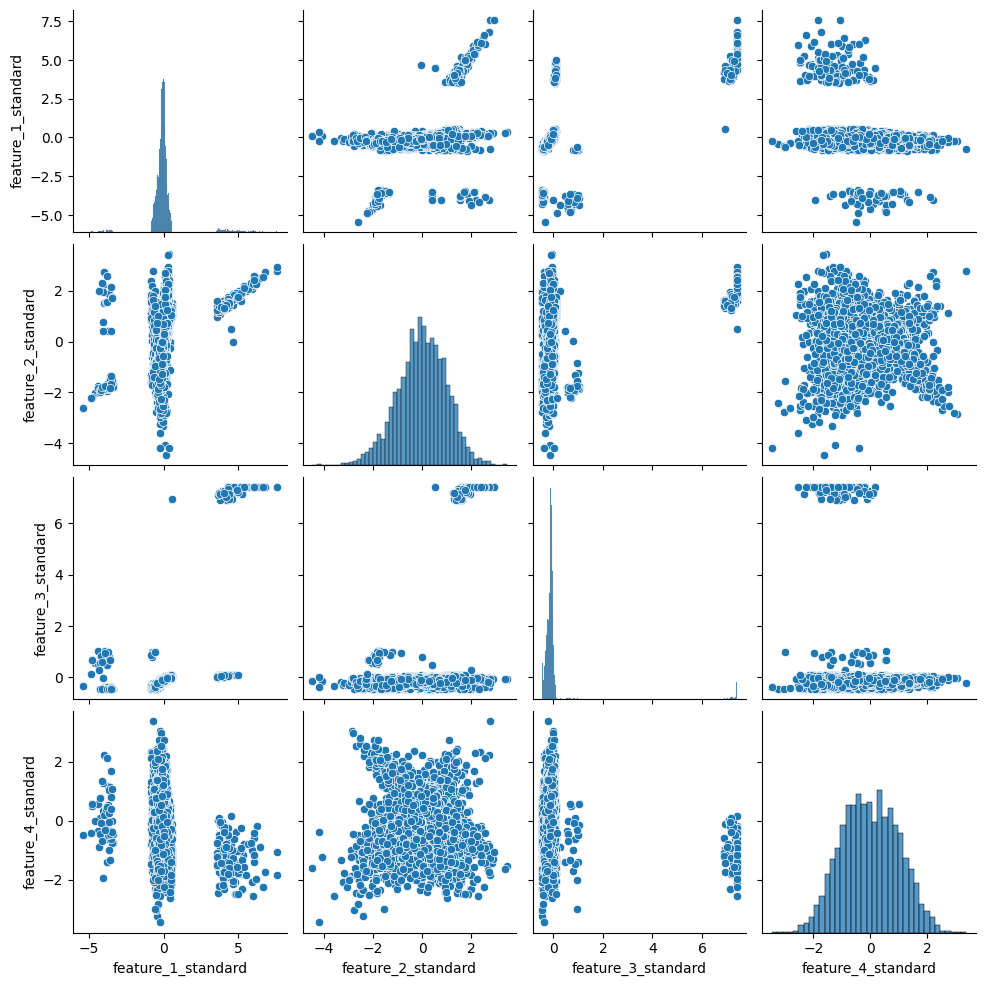

In [88]:
# making a pairplot
import seaborn as sns
sns.pairplot(train[["feature_1_standard", "feature_2_standard", "feature_3_standard", "feature_4_standard"]])

From the pairplot, I do not see a ton of evidence of multicollinearity. I would say the best argument for collinearity is between features 1 and 4.